In [1]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
VGG=K.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

In [3]:
#Averagepooling instead of max
poolindices=[3,6,11,16,21]

x=VGG.layers[0].output
for i in range(1,len(VGG.layers)):
    if i in poolindices:
        x=K.layers.AveragePooling2D()(x)
    else:
        x=VGG.layers[i](x)
    VGG.layers[i].trainable=False

VGG = Model(inputs=VGG.layers[0].input, outputs=x)
VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 128)   0     

In [4]:
#Setting every activation as output layer
outputs = [x.output for x in VGG.layers]
interVGG=tf.keras.Model([VGG.input], outputs)

In [5]:
#Loading image
im=Image.open('./deepstyle/macsek.jpg')
im=np.array(im.resize((244,244))).astype(np.float32).reshape(1,244,244,3)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(im)
pred=interVGG.predict(im)

layernum=14
targetact=pred[layernum].copy()
whiteim=np.random.rand(1,244,244,3).astype(np.float32)
img=tf.Variable(whiteim)

In [9]:
#Content reconstruction
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def contentloss(x, y):
    return tf.reduce_mean((x-y)**2)


optimizer=tf.optimizers.Adam(0.01)
def contentopt(img,targetact,layernum):
    with tf.GradientTape() as g:
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255.0)
        pred=interVGG(preprocessed_input)
        whiteact=pred[layernum]
        loss=contentloss(whiteact,targetact)
        

    gradients = g.gradient(loss,img)
    print(loss)
    optimizer.apply_gradients([(gradients, img)])
    return img


tf.Tensor(135337.0, shape=(), dtype=float32)
tf.Tensor(122726.984, shape=(), dtype=float32)
tf.Tensor(114529.34, shape=(), dtype=float32)
tf.Tensor(108513.04, shape=(), dtype=float32)
tf.Tensor(103715.27, shape=(), dtype=float32)
tf.Tensor(99634.02, shape=(), dtype=float32)
tf.Tensor(96092.51, shape=(), dtype=float32)
tf.Tensor(92959.945, shape=(), dtype=float32)
tf.Tensor(90115.086, shape=(), dtype=float32)
tf.Tensor(87494.38, shape=(), dtype=float32)
tf.Tensor(85039.35, shape=(), dtype=float32)
tf.Tensor(82689.42, shape=(), dtype=float32)
tf.Tensor(80405.1, shape=(), dtype=float32)
tf.Tensor(78215.24, shape=(), dtype=float32)
tf.Tensor(76084.34, shape=(), dtype=float32)
tf.Tensor(74044.555, shape=(), dtype=float32)
tf.Tensor(72080.15, shape=(), dtype=float32)
tf.Tensor(70206.22, shape=(), dtype=float32)
tf.Tensor(68407.945, shape=(), dtype=float32)
tf.Tensor(66672.41, shape=(), dtype=float32)
tf.Tensor(64987.586, shape=(), dtype=float32)
tf.Tensor(63359.508, shape=(), dtype=float32)


W1015 23:49:47.727135  9468 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(8124.238, shape=(), dtype=float32)
tf.Tensor(7927.115, shape=(), dtype=float32)


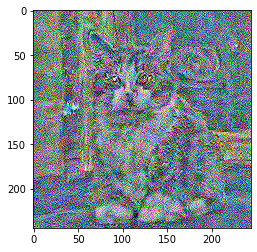

In [10]:
#Run reconstruction from layer 14
for i in range(100):
    cucc=contentopt(img,targetact,layernum)
    
plt.imshow(img.numpy().reshape(244,244,3)[:,:,::-1])
plt.show()


In [12]:
#Gram matrix for corelation calculations
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [13]:
#Load image
im=Image.open('./deepstyle/lang.jpg')
im=np.array(im.resize((244,244))).astype(np.float32).reshape(1,244,244,3)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(im)
pred=interVGG.predict(preprocessed_input)

styleidx=[1,4,7,12,17]
tstyles=[gram_matrix(tf.Variable(pred[i].copy())) for i in styleidx]
whiteim=np.random.rand(1,244,244,3).astype(np.float32)*0.1+0.5
img=tf.Variable(whiteim)

In [15]:
#Defining style loss as a corelation loss
def styleloss(layerstyles,targetstyles):
    return tf.add_n([tf.reduce_mean((layerstyles[i]-targetstyles[i])**2) 
                           for i in range(len(layerstyles))])


optimizer=tf.optimizers.Adam(0.05)

def styleopt(img,tstyles,styleidx):
    with tf.GradientTape() as g:
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255.0)
        pred=interVGG(preprocessed_input)
        wstyles=[gram_matrix(pred[i]) for i in styleidx]
        loss=styleloss(wstyles,tstyles)
        
    
    gradients = g.gradient(loss,img)
    print(loss)
    optimizer.apply_gradients([(gradients, img)])
    img.assign(clip_0_1(img))
    return img
    

tf.Tensor(271857250000.0, shape=(), dtype=float32)
tf.Tensor(265030750000.0, shape=(), dtype=float32)
tf.Tensor(243974460000.0, shape=(), dtype=float32)
tf.Tensor(215932060000.0, shape=(), dtype=float32)
tf.Tensor(196531670000.0, shape=(), dtype=float32)
tf.Tensor(175062340000.0, shape=(), dtype=float32)
tf.Tensor(159415350000.0, shape=(), dtype=float32)
tf.Tensor(147258150000.0, shape=(), dtype=float32)
tf.Tensor(137120040000.0, shape=(), dtype=float32)
tf.Tensor(127975014000.0, shape=(), dtype=float32)
tf.Tensor(119853700000.0, shape=(), dtype=float32)
tf.Tensor(112325935000.0, shape=(), dtype=float32)
tf.Tensor(105365740000.0, shape=(), dtype=float32)
tf.Tensor(98894620000.0, shape=(), dtype=float32)
tf.Tensor(92920500000.0, shape=(), dtype=float32)
tf.Tensor(87260010000.0, shape=(), dtype=float32)
tf.Tensor(81924690000.0, shape=(), dtype=float32)
tf.Tensor(76917580000.0, shape=(), dtype=float32)
tf.Tensor(72288535000.0, shape=(), dtype=float32)
tf.Tensor(67923063000.0, shape=(), dt

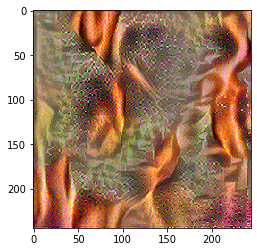

In [16]:
#Optimizing for style
for i in range(100):
    cucc=styleopt(img,tstyles,styleidx)
    
plt.imshow((img.numpy().reshape(244,244,3)))
plt.show()


In [17]:

#Putting content and style together
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def contentloss(x, y):
    return tf.reduce_mean((x-y)**2)


def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def styleloss(layerstyles,targetstyles):
    return tf.add_n([tf.reduce_mean((layerstyles[i]-targetstyles[i])**2) 
                           for i in range(len(layerstyles))])


def styleopt(img,tstyles,styleidx):
    with tf.GradientTape() as g:
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255.0)
        pred=interVGG(preprocessed_input)
        wstyles=[gram_matrix(pred[i]) for i in styleidx]
        loss=styleloss(wstyles,tstyles)
        
    
    gradients = g.gradient(loss,img)
    print(loss)
    optimizer.apply_gradients([(gradients, img)])
    img.assign(clip_0_1(img))
    return img
    

In [18]:
#Loading images for content and style

psize=350

im=Image.open('./deepstyle/lang.jpg')
im=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(im)
pred=interVGG.predict(preprocessed_input)

styleidx=[1,4,7,12,17]
tstyles=[gram_matrix(tf.Variable(pred[i].copy())) for i in styleidx]
whiteim=np.random.rand(1,psize,psize,3).astype(np.float32)
img=tf.Variable(whiteim)



im=Image.open('./deepstyle/gergo.jpg')
im=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)
preprocessed_input = tf.keras.applications.vgg19.preprocess_input(im)
pred=interVGG.predict(preprocessed_input)

layernum=12
targetact=pred[layernum].copy()
im=Image.open('./deepstyle/gergo.jpg')
whiteim=np.array(im.resize((psize,psize))).astype(np.float32).reshape(1,psize,psize,3)[:,:,:,::-1]/255.0
img=tf.Variable(whiteim)




In [19]:
#Merged opt. function for style transfer
acont=1e1
astyle=1e-1
avar=0
optimizer=tf.optimizers.Adam(0.01)

def mergeopt(img,acont,astyle,tstyles,styleidx,targetact,layernum):
    with tf.GradientTape() as g:
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(img*255)
        pred=interVGG(preprocessed_input)
        wstyles=[gram_matrix(pred[i]) for i in styleidx]
        whiteact=pred[layernum]
        loss=astyle*styleloss(wstyles,tstyles)/len(styleidx)+acont*contentloss(whiteact,targetact)
        
    
    gradients = g.gradient(loss,img)
    optimizer.apply_gradients([(gradients, img)])
    img.assign(clip_0_1(img))
    return loss

tf.Tensor(259010290.0, shape=(), dtype=float32)


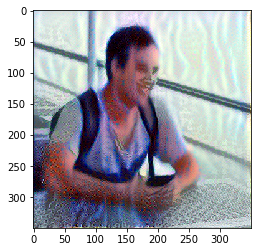

In [21]:
#Run style transfer
with tf.device('/GPU:0'):
    for i in range(50):
        cucc=mergeopt(img,acont,astyle,tstyles,styleidx,targetact,layernum)
        if i % 50==0:
            print(cucc)

    plt.imshow((img.numpy().reshape(psize,psize,3)[:,:,::-1]))
    plt.show()
    saveimage = Image.fromarray((img.numpy().reshape(psize,psize,3)[:,:,::-1]*255).astype('uint8'), 'RGB')
    saveimage.save('./deepstyle/result.jpg')